<a href="https://colab.research.google.com/github/ra1ph2/Vision-Transformer/blob/main/VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Libraries Imported

In [ ]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  Tesla T4


#### Model Architecture

##### Vision Transformer

In [ ]:
class Attention(nn.Module):
    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key   = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key   = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) | Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)
        
        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [ ]:
attention = Attention(embed_dim=4, heads=2, activation=None)
attention_lib = nn.MultiheadAttention(embed_dim=4, num_heads=2)
inp = torch.ones((1, 2, 4))
print(inp)
out, wts = attention(inp)
print(out)
print(wts)
out_lib, out_wts = attention_lib(inp.permute(1, 0, 2), inp.permute(1, 0, 2), inp.permute(1, 0, 2))
print(out_lib.permute(1, 0, 2))
print(out_wts)

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.]]])
tensor([[[-0.0226,  0.1413,  1.8655,  0.6221],
         [-0.0226,  0.1413,  0.9328,  0.3110]]], grad_fn=<UnsafeViewBackward>)
tensor([[[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]]], grad_fn=<SoftmaxBackward>)
tensor([[[-0.0627, -0.2031,  0.1151, -0.1255],
         [-0.0627, -0.2031,  0.1151, -0.1255]]], grad_fn=<PermuteBackward>)
tensor([[[0.5000, 0.5000],
         [0.5000, 0.5000]]], grad_fn=<DivBackward0>)


In [ ]:
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out 

In [ ]:
ff = FeedForward(8, 1)
inp = torch.ones((1, 2, 8))
print(inp)
out = ff(inp)
print(out)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]]])
tensor([[[ 0.6172, -0.2359,  0.3735,  0.4006,  0.6115, -0.1680,  0.0109,
           0.3630],
         [ 0.6857, -0.1970,  0.3759,  0.4234,  0.5197, -0.2043, -0.0755,
           0.3753]]], grad_fn=<AddBackward0>)


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res
        
        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out

In [ ]:
tb = TransformerBlock(8, 2)
inp = torch.ones((1, 2, 8))
print(inp)
out = tb(inp)
print(out)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]]])
tensor([[[0.6649, 1.8659, 0.9776, 0.6647, 0.8021, 0.9819, 1.0266, 0.1721],
         [0.6052, 1.8529, 0.9518, 0.6406, 0.8101, 1.0238, 1.0076, 0.2162]]],
       grad_fn=<AddBackward0>)


In [ ]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, layers, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout) for i in range(layers)]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [ ]:
tb = TransformerBlock(8, 2)
trans = Transformer(8, 1, 2)
inp = torch.ones((1, 2, 8))
print(inp)
out = tb(inp)
print(out)
out = trans(inp)
print(out)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]]])
tensor([[[0.3119, 1.2377, 1.0935, 1.2006, 0.9946, 1.3895, 0.8329, 1.6715],
         [0.3403, 1.2386, 1.1339, 1.1572, 0.9900, 1.3469, 0.8077, 1.7098]]],
       grad_fn=<AddBackward0>)
tensor([[[1.4537, 0.9954, 1.0907, 0.7924, 1.3261, 0.4193, 1.3382, 0.8223],
         [1.4537, 0.9954, 1.0907, 0.7924, 1.3261, 0.4193, 1.3382, 0.8223]]],
       grad_fn=<AddBackward0>)


In [ ]:
# Not Exactly Same as Paper | Check if Dropout should be used here
class ClassificationHead(nn.Module):
    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, embed_dim) | SoftMaxed along the last dimension
        return out

In [ ]:
ch = ClassificationHead(8, 2)
inp = torch.ones((2, 8))
print(inp)
out = ch(inp)
print(out)

tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.0069, 0.5710],
        [0.0069, 0.5710]], grad_fn=<AddmmBackward>)


In [ ]:
#TODO: Remove to.device from class_token
class VisionTransformer(nn.Module):
    def __init__(self, patch_size, max_len, embed_dim, classes, layers, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.name = 'VisionTransformer'
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_to_embed = nn.Linear(patch_size * patch_size * 3, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, 3, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == 3

        out = inp.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).contiguous()
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, 3) | seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()
        
        out = out.reshape(batch_size, seq_len, -1)
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[:seq_len+1]
        position_embed = position_embed.unsqueeze(0).expand(batch_size, seq_len+1, self.embed_dim)
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim) 
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)
        
        return class_out, out

In [ ]:
vit = VisionTransformer(2, 3, 8, 2, 2).to(device)
inp = torch.ones((2, 3, 2, 2)).to(device)
print(inp)
class_out, out = vit(inp)
print(class_out)
print(class_out.shape)
print(out)
print(out.shape)

tensor([[[[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]]],


        [[[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]]]], device='cuda:0')
tensor([[ 0.6623, -0.7030],
        [ 0.1802, -0.5347]], device='cuda:0', grad_fn=<AddmmBackward>)
torch.Size([2, 2])
tensor([[[-1.2980,  2.9821, -1.2093,  3.7188,  0.5311,  0.1910, -0.3155,
           0.1397],
         [-0.4279,  0.4978, -2.1513,  3.1216, -1.7643, -0.4783,  1.8726,
          -1.3458]],

        [[-0.1632,  2.4125, -1.0862,  3.7725,  0.5579,  0.2841, -0.5910,
           0.1642],
         [-0.3908,  0.8742, -2.0072,  2.8123, -1.7472, -0.0781,  2.5029,
          -1.4645]]], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([2, 2, 8])


##### ResNet

In [ ]:
class ResidualBlockSmall(nn.Module):
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1):
        super(ResidualBlockSmall, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels * expansion, height, width) | height, width depending on stride
        return out

In [ ]:
class ResNetSmall(nn.Module):
    def __init__(self, layers, input_channels, classes):
        super(ResNetSmall, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=64, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=128, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=256, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        if stride != 1:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels)
            )
        
        layers.append(ResidualBlockSmall(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockSmall(output_channels, output_channels))

        return nn.Sequential(*layers)

In [ ]:
class ResidualBlockLarge(nn.Module):
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1, expansion=4):
        super(ResidualBlockLarge, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * expansion, kernel_size=1, stride=1, padding=0)
        self.bnorm3 = nn.BatchNorm2d(out_channels * expansion)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        out = self.activation(self.bnorm3(self.conv3(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels * expansion, height, width) | height, width depending on stride
        return out

In [ ]:
class ResNetLarge(nn.Module):
    def __init__(self, layers, input_channels, classes):
        super(ResNetLarge, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=256, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=512, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=1024, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        # 4 is the value of the expansion for large ResNets
        if stride != 1 or input_channels != output_channels * 4:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockLarge(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockLarge(output_channels * 4, output_channels))

        return nn.Sequential(*layers)

In [ ]:
def ResNet34(input_channels, classes):
    return ResNetSmall([3, 4, 6, 3], input_channels, classes)

In [ ]:
def ResNet50(input_channels, classes):
    return ResNetLarge([3, 4, 6, 3], input_channels, classes)

#### Data Loading

In [ ]:
def CIFAR100DataLoader(split, batch_size=8, num_workers=2, shuffle=True):

    CIFAR100_TRAIN_MEAN = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
    CIFAR100_TRAIN_STD = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
    
    mean = CIFAR100_TRAIN_MEAN
    std = CIFAR100_TRAIN_STD

    if split == 'train':
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop((224,224), scale=(0.5, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
        ])

        # train_transform = transforms.Compose([
        #     transforms.RandomCrop(32, padding=4),
        #     transforms.RandomHorizontalFlip(),
        #     transforms.RandomRotation(15),
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean, std)
        # ])
        
        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
        ])

        # test_transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean, std)
        # ])

        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

In [ ]:
def CIFAR10DataLoader(split, batch_size=8, num_workers=2, shuffle=True):

    if split == 'train':
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop((224,224), scale=(0.5, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
        ])

        # train_transform = transforms.Compose([
        #     transforms.RandomCrop(32, padding=4),
        #     transforms.RandomHorizontalFlip(),
        #     transforms.RandomRotation(15),
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
        # ])
        
        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        test_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
        ])

        # test_transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
        # ])

        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

#### Training and Evaluation

In [ ]:
lr = 0.003
batch_size = 64
num_workers = 2
shuffle = True
patch_size = 4
image_sz = 32
max_len = ((image_sz//patch_size) * (image_sz//patch_size)) + 1 # +1 for the class token
embed_dim = 512
classes = 100
layers = 8
heads = 16
epochs = 100

In [ ]:
def train(model, dataloader, criterion, optimizer, scheduler):
    
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)

        if model.name == 'VisionTransformer':
            output, _ = model(data)
        elif model.name == 'ResNet':
            output = model(data)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy

In [ ]:
def evaluation(model, dataloader, criterion):

    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == 'VisionTransformer':
                output, _ = model(data)
            elif model.name == 'ResNet':
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy

##### Model - Vision Transformer

In [ ]:
model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    heads=heads).to(device)

##### Model - ResNet50 or ResNet34

In [ ]:
model = ResNet34(
    input_channels=3,
    classes=classes).to(device)

In [ ]:
model = ResNet50(
    input_channels=3,
    classes=classes).to(device)

##### Model Training

In [ ]:
train_dataloader = CIFAR100DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
test_dataloader = CIFAR100DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './drive/MyDrive/VisionTransformer/ResNet34_100_checkpoint.pt')

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 1 - acc: 0.1205 - loss : 3.7644



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.1924 - test loss : 3.3589



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 2 - acc: 0.2463 - loss : 3.0454



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.3209 - test loss : 2.6669



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 3 - acc: 0.3488 - loss : 2.5050



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.4029 - test loss : 2.2597



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 4 - acc: 0.4325 - loss : 2.1279



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.4655 - test loss : 1.9784



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 5 - acc: 0.4943 - loss : 1.8531



100%|██████████| 157/157 [00:22<00:00,  7.10it/s]


test acc: 0.5247 - test loss : 1.7321



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 6 - acc: 0.5391 - loss : 1.6583



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.5450 - test loss : 1.6453



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 7 - acc: 0.5803 - loss : 1.4997



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.5719 - test loss : 1.5333



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 8 - acc: 0.6154 - loss : 1.3655



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.5841 - test loss : 1.4742



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 9 - acc: 0.6420 - loss : 1.2445



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6078 - test loss : 1.3932



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 10 - acc: 0.6696 - loss : 1.1456



100%|██████████| 157/157 [00:22<00:00,  6.99it/s]


test acc: 0.6188 - test loss : 1.3578



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 11 - acc: 0.6911 - loss : 1.0590



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6309 - test loss : 1.3219



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 12 - acc: 0.7159 - loss : 0.9689



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6342 - test loss : 1.2805



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 13 - acc: 0.7330 - loss : 0.8970



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6372 - test loss : 1.2853



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 14 - acc: 0.7546 - loss : 0.8246



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6487 - test loss : 1.2568



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 15 - acc: 0.7716 - loss : 0.7626



100%|██████████| 157/157 [00:22<00:00,  7.06it/s]


test acc: 0.6575 - test loss : 1.2259



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 16 - acc: 0.7890 - loss : 0.7043



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6586 - test loss : 1.2432



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 17 - acc: 0.8059 - loss : 0.6451



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6582 - test loss : 1.2409



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 18 - acc: 0.8167 - loss : 0.5991



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6638 - test loss : 1.2273



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 19 - acc: 0.8330 - loss : 0.5492



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6622 - test loss : 1.2674



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 20 - acc: 0.8396 - loss : 0.5192



100%|██████████| 157/157 [00:22<00:00,  7.01it/s]


test acc: 0.6676 - test loss : 1.2551



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 21 - acc: 0.8563 - loss : 0.4678



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6748 - test loss : 1.2271



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 22 - acc: 0.8708 - loss : 0.4273



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6717 - test loss : 1.2315



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 23 - acc: 0.8728 - loss : 0.4126



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6771 - test loss : 1.2467



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 24 - acc: 0.8820 - loss : 0.3773



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6703 - test loss : 1.2818



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 25 - acc: 0.8893 - loss : 0.3547



100%|██████████| 157/157 [00:22<00:00,  7.13it/s]


test acc: 0.6767 - test loss : 1.2744



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 26 - acc: 0.8967 - loss : 0.3326



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6713 - test loss : 1.3017



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 27 - acc: 0.9039 - loss : 0.3117



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6767 - test loss : 1.3045



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 28 - acc: 0.9090 - loss : 0.2930



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6780 - test loss : 1.2909



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 29 - acc: 0.9140 - loss : 0.2789



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6736 - test loss : 1.3295



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 30 - acc: 0.9164 - loss : 0.2674



100%|██████████| 157/157 [00:22<00:00,  7.01it/s]


test acc: 0.6733 - test loss : 1.3539



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 31 - acc: 0.9225 - loss : 0.2469



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6716 - test loss : 1.3658



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 32 - acc: 0.9252 - loss : 0.2418



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6783 - test loss : 1.3503



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 33 - acc: 0.9264 - loss : 0.2344



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6789 - test loss : 1.3703



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 34 - acc: 0.9311 - loss : 0.2226



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6748 - test loss : 1.3683



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 35 - acc: 0.9369 - loss : 0.2016



100%|██████████| 157/157 [00:21<00:00,  7.22it/s]


test acc: 0.6787 - test loss : 1.3834



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 36 - acc: 0.9384 - loss : 0.1995



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6828 - test loss : 1.3741



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 37 - acc: 0.9418 - loss : 0.1879



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6765 - test loss : 1.4120



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 38 - acc: 0.9395 - loss : 0.1911



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6820 - test loss : 1.4193



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 39 - acc: 0.9419 - loss : 0.1901



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6884 - test loss : 1.3943



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 40 - acc: 0.9443 - loss : 0.1773



100%|██████████| 157/157 [00:21<00:00,  7.22it/s]


test acc: 0.6845 - test loss : 1.4005



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 41 - acc: 0.9487 - loss : 0.1667



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6834 - test loss : 1.4138



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 42 - acc: 0.9477 - loss : 0.1676



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6889 - test loss : 1.4093



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 43 - acc: 0.9509 - loss : 0.1568



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6806 - test loss : 1.4414



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 44 - acc: 0.9520 - loss : 0.1548



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6757 - test loss : 1.4773



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 45 - acc: 0.9539 - loss : 0.1494



100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


test acc: 0.6739 - test loss : 1.5010



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 46 - acc: 0.9517 - loss : 0.1533



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6807 - test loss : 1.4772



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 47 - acc: 0.9547 - loss : 0.1454



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6738 - test loss : 1.4877



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 48 - acc: 0.9562 - loss : 0.1411



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6769 - test loss : 1.4831



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 49 - acc: 0.9586 - loss : 0.1323



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6805 - test loss : 1.4975



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 50 - acc: 0.9587 - loss : 0.1333



100%|██████████| 157/157 [00:21<00:00,  7.28it/s]


test acc: 0.6793 - test loss : 1.4997



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 51 - acc: 0.9588 - loss : 0.1330



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6766 - test loss : 1.5348



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 52 - acc: 0.9626 - loss : 0.1210



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6782 - test loss : 1.5437



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 53 - acc: 0.9612 - loss : 0.1261



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6898 - test loss : 1.5245



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 54 - acc: 0.9625 - loss : 0.1191



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6871 - test loss : 1.5037



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 55 - acc: 0.9645 - loss : 0.1172



100%|██████████| 157/157 [00:22<00:00,  6.95it/s]


test acc: 0.6815 - test loss : 1.5405



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 56 - acc: 0.9626 - loss : 0.1168



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6829 - test loss : 1.5145



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 57 - acc: 0.9660 - loss : 0.1094



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6808 - test loss : 1.5126



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 58 - acc: 0.9643 - loss : 0.1133



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6818 - test loss : 1.5208



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 59 - acc: 0.9660 - loss : 0.1087



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6805 - test loss : 1.5327



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 60 - acc: 0.9668 - loss : 0.1039



100%|██████████| 157/157 [00:22<00:00,  7.04it/s]


test acc: 0.6829 - test loss : 1.5316



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 61 - acc: 0.9668 - loss : 0.1020



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6820 - test loss : 1.5706



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 62 - acc: 0.9676 - loss : 0.1032



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6815 - test loss : 1.5802



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 63 - acc: 0.9693 - loss : 0.0988



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6927 - test loss : 1.5255



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 64 - acc: 0.9677 - loss : 0.1001



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6873 - test loss : 1.5497



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 65 - acc: 0.9699 - loss : 0.0982



100%|██████████| 157/157 [00:21<00:00,  7.18it/s]


test acc: 0.6879 - test loss : 1.5651



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 66 - acc: 0.9681 - loss : 0.1014



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6838 - test loss : 1.5795



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 67 - acc: 0.9717 - loss : 0.0908



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6895 - test loss : 1.5529



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 68 - acc: 0.9711 - loss : 0.0927



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6774 - test loss : 1.6145



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 69 - acc: 0.9733 - loss : 0.0867



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6888 - test loss : 1.5641



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 70 - acc: 0.9726 - loss : 0.0894



100%|██████████| 157/157 [00:22<00:00,  7.14it/s]


test acc: 0.6887 - test loss : 1.5886



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 71 - acc: 0.9713 - loss : 0.0909



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6786 - test loss : 1.6324



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 72 - acc: 0.9716 - loss : 0.0903



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6817 - test loss : 1.6205



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 73 - acc: 0.9729 - loss : 0.0868



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6814 - test loss : 1.6139



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 74 - acc: 0.9730 - loss : 0.0851



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6838 - test loss : 1.6237



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 75 - acc: 0.9761 - loss : 0.0786



100%|██████████| 157/157 [00:22<00:00,  7.07it/s]


test acc: 0.6890 - test loss : 1.6027



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 76 - acc: 0.9734 - loss : 0.0849



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6865 - test loss : 1.6059



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 77 - acc: 0.9758 - loss : 0.0776



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6845 - test loss : 1.6154



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 78 - acc: 0.9736 - loss : 0.0853



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6913 - test loss : 1.5883



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 79 - acc: 0.9745 - loss : 0.0818



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6874 - test loss : 1.6072



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 80 - acc: 0.9773 - loss : 0.0707



100%|██████████| 157/157 [00:22<00:00,  6.96it/s]


test acc: 0.6877 - test loss : 1.6237



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 81 - acc: 0.9746 - loss : 0.0806



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6930 - test loss : 1.5975



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 82 - acc: 0.9756 - loss : 0.0768



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6845 - test loss : 1.6175



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 83 - acc: 0.9784 - loss : 0.0693



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6885 - test loss : 1.6186



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 84 - acc: 0.9770 - loss : 0.0725



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6865 - test loss : 1.6384



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 85 - acc: 0.9768 - loss : 0.0739



100%|██████████| 157/157 [00:22<00:00,  6.98it/s]


test acc: 0.6897 - test loss : 1.6141



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 86 - acc: 0.9772 - loss : 0.0723



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6860 - test loss : 1.6447



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 87 - acc: 0.9768 - loss : 0.0736



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6823 - test loss : 1.6741



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 88 - acc: 0.9790 - loss : 0.0676



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6920 - test loss : 1.6226



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 89 - acc: 0.9786 - loss : 0.0685



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6899 - test loss : 1.6206



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 90 - acc: 0.9792 - loss : 0.0669



100%|██████████| 157/157 [00:22<00:00,  7.02it/s]


test acc: 0.6869 - test loss : 1.6547



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 91 - acc: 0.9785 - loss : 0.0687



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6886 - test loss : 1.6273



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 92 - acc: 0.9792 - loss : 0.0673



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6874 - test loss : 1.6730



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 93 - acc: 0.9798 - loss : 0.0661



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6798 - test loss : 1.6774



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 94 - acc: 0.9799 - loss : 0.0649



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6893 - test loss : 1.6534



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 95 - acc: 0.9796 - loss : 0.0633



100%|██████████| 157/157 [00:22<00:00,  6.96it/s]


test acc: 0.6869 - test loss : 1.6913



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 96 - acc: 0.9805 - loss : 0.0626



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6824 - test loss : 1.7031



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 97 - acc: 0.9809 - loss : 0.0621



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6848 - test loss : 1.6908



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 98 - acc: 0.9804 - loss : 0.0617



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6925 - test loss : 1.6610



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 99 - acc: 0.9802 - loss : 0.0625



  0%|          | 0/782 [00:00<?, ?it/s]

test acc: 0.6865 - test loss : 1.6758



  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 100 - acc: 0.9820 - loss : 0.0587



100%|██████████| 157/157 [00:21<00:00,  7.14it/s]


test acc: 0.6932 - test loss : 1.6929



[0.12048427015542984, 0.24634331464767456, 0.3487849831581116, 0.432524710893631, 0.49432501196861267, 0.5390821695327759, 0.5803226828575134, 0.615388810634613, 0.641963541507721, 0.6695565581321716, 0.6910563111305237, 0.7158523797988892, 0.7329756617546082, 0.754554808139801, 0.7715999484062195, 0.7890225648880005, 0.8058860898017883, 0.8166953325271606, 0.8330399394035339, 0.8395932912826538, 0.8562577962875366, 0.8707637190818787, 0.872800886631012, 0.8819527626037598, 0.8892661333084106, 0.8966785669326782, 0.9039317965507507, 0.909046471118927, 0.9140418767929077, 0.9164202809333801, 0.9225143194198608, 0.925212025642395, 0.9263709783554077, 0.9310662746429443, 0.936901330947876, 0.938360333442688, 0.9417571425437927, 0.9394792914390564, 0.9418771862983704, 0.9443148374557495, 0.9487304091453552, 0.9477311372756958, 0.9509085416793823, 0.951987624168396, 0.9538856744766235, 0.9517478942871094, 0.9547047019004822, 0.9562434554100037, 0.9586211442947388, 0.9586612582206726, 0.9588

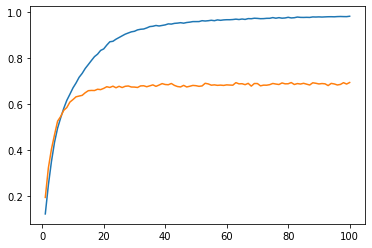

In [ ]:
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
print(train_accs)
print(test_accs)

plt.plot(range(1, 101), train_accs, range(1, 101), test_accs)